In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets, preprocessing, model_selection, ensemble, pipeline
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
#from evidently.dashboard import Dashboard
#from evidently.tabs import ClassificationPerformanceTab
#from evidently.tabs import DataDriftTab
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
import shap
from sklearn.metrics import roc_auc_score, make_scorer

In [101]:
!pip install numpy==1.21.5
!pip install sklearn==1.1.2
!pip install threadpoolctl==2.2.0

ERROR: Could not find a version that satisfies the requirement sklearn==1.1.2 (from versions: 0.0, 0.0.post1, 0.0.post2, 0.0.post4, 0.0.post5)
ERROR: No matching distribution found for sklearn==1.1.2


In [102]:
import mlflow
from mlflow import MlflowClient
mlflow.sklearn.autolog()

2023/05/19 14:03:05 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


# Import des différents dataframes

In [103]:
df_app_train             = pd.read_csv("application_train.csv")
df_app_test              = pd.read_csv("application_test.csv")
df_bureau                = pd.read_csv("bureau.csv")
df_bureau_balance        = pd.read_csv("bureau_balance.csv")
df_credit_card_balance   = pd.read_csv("credit_card_balance.csv")
df_installments_payments = pd.read_csv("installments_payments.csv")
df_previous_application  = pd.read_csv("previous_application.csv")
df_POS_CASH_balance      = pd.read_csv("POS_CASH_balance.csv")
df_sample_submission     = pd.read_csv("sample_submission.csv")

# Premiers traitements initiaux

In [104]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
        df.to_csv("df_scoring.csv")
        return df

In [105]:
import pandas as pd
df0=pd.read_csv("df_scoring.csv")
df0.head()

,Unnamed: 0,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,0,100002,1.0,0,0,0,0,202500.0,406597.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,100004,0.0,0,1,0,0,67500.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,100006,0.0,1,0,0,0,135000.0,312682.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,4,100007,0.0,0,0,0,0,121500.0,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
df0.shape

(356251, 799)

In [107]:
df0.columns.isnull()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [108]:
df0=df0.sample(356200)

In [109]:
df0.to_csv("df_sample.csv")

In [110]:
import pandas as pd
df0 = pd.read_csv('df_sample.csv')

In [111]:
df0=df0.sample(350000)

# Appropriation du Dataframe par nettoyage

#### Pourcentage de valeurs manquantes

In [112]:
pourcentage_valeurs_manquantes = df0.isna().mean() * 100

print(pourcentage_valeurs_manquantes)

Unnamed: 0.1                         0.000000
Unnamed: 0                           0.000000
index                                0.000000
SK_ID_CURR                           0.000000
TARGET                              13.676571
                                      ...    
CC_NAME_CONTRACT_STATUS_nan_MAX     70.926286
CC_NAME_CONTRACT_STATUS_nan_MEAN    70.926286
CC_NAME_CONTRACT_STATUS_nan_SUM     70.926286
CC_NAME_CONTRACT_STATUS_nan_VAR     71.120571
CC_COUNT                            70.926286
Length: 800, dtype: float64


#### Remplacement de valeurs infinies par des valeurs finies

In [113]:
df0 = pd.DataFrame(np.nan_to_num(df0), columns=df0.columns)
df0.head()

,Unnamed: 0.1,Unnamed: 0,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,44160.0,44162.0,44162.0,151159.0,0.0,0.0,0.0,0.0,1.0,225000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4205.0,4205.0,4205.0,104920.0,0.0,1.0,1.0,1.0,1.0,67500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,196382.0,196386.0,196386.0,327707.0,0.0,1.0,0.0,1.0,0.0,225000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
3,58418.0,58420.0,58420.0,167719.0,0.0,1.0,0.0,0.0,1.0,180000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,39339.0,39341.0,39341.0,145559.0,0.0,1.0,0.0,0.0,0.0,90000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
df0.shape

(350000, 800)

#### Imputation par K plus proches voisins et remplacements des valeurs manquantes

In [115]:
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df0), columns=df0.columns)

#### Vérification de la binarité parfaite des valeurs de la Target

In [116]:
df['TARGET'].unique()

array([0., 1.])

In [117]:
df.head()

,Unnamed: 0.1,Unnamed: 0,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,44160.0,44162.0,44162.0,151159.0,0.0,0.0,0.0,0.0,1.0,225000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4205.0,4205.0,4205.0,104920.0,0.0,1.0,1.0,1.0,1.0,67500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,196382.0,196386.0,196386.0,327707.0,0.0,1.0,0.0,1.0,0.0,225000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
3,58418.0,58420.0,58420.0,167719.0,0.0,1.0,0.0,0.0,1.0,180000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,39339.0,39341.0,39341.0,145559.0,0.0,1.0,0.0,0.0,0.0,90000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Suppression de la colonne SK_ID_CURR qui sera réindexée à posteriori 

In [118]:
df = df.drop("SK_ID_CURR", axis=1)

# Isolement des 20 premières colonnes ayant le plus fort taux de corrélation avec la colonne TARGET

In [119]:
target_corr = df.corrwith(df['TARGET']).sort_values(ascending=False)

overflow encountered in reduce


In [120]:
# Obtenir les 20 plus fortes corrélations
top_corr = target_corr[:200]
print(top_corr)

TARGET                                    1.000000
BURO_DAYS_CREDIT_MEAN                     0.079226
DAYS_BIRTH                                0.072772
PREV_NAME_CONTRACT_STATUS_Refused_MEAN    0.070781
BURO_DAYS_CREDIT_MIN                      0.068954
                                            ...   
ORGANIZATION_TYPE_Restaurant              0.009515
PREV_NAME_CONTRACT_TYPE_XNA_MEAN          0.009352
PREV_PRODUCT_COMBINATION_nan_MEAN         0.009352
BURO_STATUS_3_MEAN_MEAN                   0.009343
CC_NAME_CONTRACT_STATUS_Active_MEAN       0.009266
Length: 200, dtype: float64


#### Création d'un Dataframe rassemblant les vingt plus fortes corrélations de la colonne TARGET

In [121]:
top_corr_cols = target_corr[:200].index.tolist()
df = df[top_corr_cols]
df.head()

,TARGET,BURO_DAYS_CREDIT_MEAN,DAYS_BIRTH,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,BURO_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,REGION_RATING_CLIENT_W_CITY,...,INSTAL_DPD_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_PAYMENT_CURRENT_VAR,BURO_STATUS_5_MEAN_MEAN,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Restaurant,PREV_NAME_CONTRACT_TYPE_XNA_MEAN,PREV_PRODUCT_COMBINATION_nan_MEAN,BURO_STATUS_3_MEAN_MEAN,CC_NAME_CONTRACT_STATUS_Active_MEAN
0,0.0,-1358.869565,-14735.0,0.000000,-2740.0,-2740.0,-1626.75,-993.565217,0.0,2.0,...,0.480769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-1664.000000,-13408.0,0.000000,-2590.0,-2590.0,-1664.00,-1433.000000,0.0,2.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-1314.500000,-18888.0,0.000000,-1516.0,-1516.0,-1516.00,-489.500000,0.0,2.0,...,0.105263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,-666.545455,-10587.0,0.142857,-1221.0,-1221.0,-975.50,-228.454545,0.0,2.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-744.500000,-8343.0,0.000000,-1126.0,0.0,0.00,-16.500000,0.0,2.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
print (top_corr_cols)

['TARGET', 'BURO_DAYS_CREDIT_MEAN', 'DAYS_BIRTH', 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 'BURO_DAYS_CREDIT_MIN', 'CLOSED_DAYS_CREDIT_MIN', 'CLOSED_DAYS_CREDIT_MEAN', 'BURO_DAYS_CREDIT_UPDATE_MEAN', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'REGION_RATING_CLIENT_W_CITY', 'DAYS_LAST_PHONE_CHANGE', 'CLOSED_MONTHS_BALANCE_MIN_MIN', 'REGION_RATING_CLIENT', 'BURO_MONTHS_BALANCE_MIN_MIN', 'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN', 'NAME_INCOME_TYPE_Working', 'CLOSED_DAYS_CREDIT_UPDATE_MEAN', 'PREV_CODE_REJECT_REASON_SCOFR_MEAN', 'BURO_DAYS_CREDIT_MAX', 'index', 'CC_CNT_DRAWINGS_CURRENT_MAX', 'DAYS_ID_PUBLISH', 'PREV_CODE_REJECT_REASON_HC_MEAN', 'REG_CITY_NOT_WORK_CITY', 'BURO_CREDIT_ACTIVE_Active_MEAN', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'REFUSED_HOUR_APPR_PROCESS_START_MAX', 'CLOSED_DAYS_CREDIT_MAX', 'CC_AMT_BALANCE_MEAN', 'CC_CNT_DRAWINGS_ATM_CURRENT_MAX', 'CC_AMT_TOTAL_RECEIVABLE_MEAN', 'CC_AMT_RECIVABLE_MEAN', 'CC_AMT_RECEIVABLE_PRINCIPAL_MEAN', 'FLAG_EMP_PHONE', 'DAYS_EMPLOYED

#### Transformation des valeurs de la colonne TARGET en valeurs intégrales

In [123]:
df['TARGET'] = df['TARGET'].astype(int)
df['TARGET'].unique()

array([0, 1])

In [124]:
df.shape

(350000, 200)

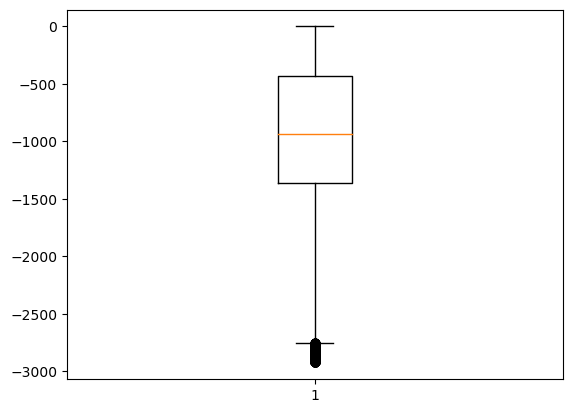

In [125]:
plt.boxplot(df["BURO_DAYS_CREDIT_MEAN"])
plt.show()

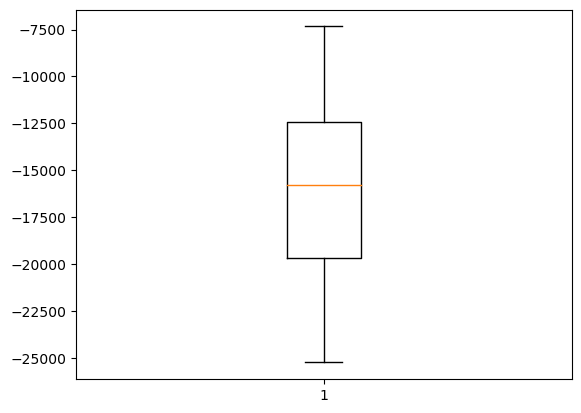

In [126]:
plt.boxplot(df["DAYS_BIRTH"])
plt.show()

In [127]:
#plt.boxplot(df["BURO_DAYS_CREDIT_MIN"])
#plt.show()

# Séparation des données

In [128]:
# Extraction de la variable cible TARGET
y = df.iloc[:, 0]

# Extraction des variables explicatives
X = df.iloc[:, 1:] 

# Stigmatisation des données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Dimension des ensembles de données

In [129]:
print("Taille de X_train :", X_train.shape)
print("Taille de X_test :", X_test.shape)
print("Taille de y_train :", y_train.shape)
print("Taille de y_test :", y_test.shape)

Taille de X_train : (280000, 199)
Taille de X_test : (70000, 199)
Taille de y_train : (280000,)
Taille de y_test : (70000,)


# Egalisation des labels 1 et 0 de la TARGET

In [130]:
print("Label 1, Avant utilisation SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Après utilisation SMOTE: {} ".format(sum(y_train==0)))

Label 1, Avant utilisation SMOTE: 19358 
Label 0, Après utilisation SMOTE: 260642 


In [131]:
# Sous-échantillonnage SMOTE pour équilibrer les classes
oversample = SMOTE()
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)

2023/05/19 14:06:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1a7df29857e547428da4777605933fb7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/05/19 14:06:07 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/05/19 14:06:07 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/05/19 14:06:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [132]:
# Affichage du nombre d'échantillons dans chaque classe avant et après SMOTE
print("Avant SMOTE :")
print(y_train.value_counts())
print("\nAprès SMOTE :")
print(y_train_resampled.value_counts())

Avant SMOTE :
0    260642
1     19358
Name: TARGET, dtype: int64

Après SMOTE :
0    260642
1    260642
Name: TARGET, dtype: int64


In [133]:
X_train=X_train_resampled
y_train=y_train_resampled

#### Dimensions des ensembles X_train et y_train

In [134]:
X_train.shape

(521284, 199)

In [135]:
y_train.shape

(521284,)

# Préprocessing des données

#### Phase de standardisation des variables X_train et X_test

In [136]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Application d'une régression logistique

In [137]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Calcul des probabilités de prédiction pour la classe positive
y_pred_lr_proba = lr.predict_proba(X_test_scaled)[:, 1]

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_lr_proba)

print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1 score:", f1_lr)
print("AUC:", auc_lr)

2023/05/19 14:06:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd90c65e8d95c4aa4be8323ffb51a4f92', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy: 0.6751571428571429
Precision: 0.13470968805373554
Recall: 0.65249500998004
F1 score: 0.22331523038562698
AUC: 0.7246259811504856


In [138]:
# Calcul des scores pour la régression logistique
y_pred = lr.predict(X_test_scaled)
precision_logreg, recall_logreg, f1_score_logreg, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print("Régression logistique - Précision : {:.2f}, Rappel : {:.2f}, F1-score : {:.2f}".format(precision_logreg, recall_logreg, f1_score_logreg))

Régression logistique - Précision : 0.13, Rappel : 0.65, F1-score : 0.22


#### Validation croisée

In [139]:
# Définir les hyperparamètres à tester
param_grid = {
    'C': [0.1, 1, 10]}

# Créer un modèle de régression logistique
model = LogisticRegression(random_state=42)

# Définir la métrique à optimiser (AUC)
scoring = {'AUC': make_scorer(roc_auc_score)}

# Créer l'objet GridSearchCV pour la recherche des meilleurs hyperparamètres
grid_search = GridSearchCV(model, param_grid, scoring=scoring, refit='AUC', cv=5)

# Adapter le modèle sur les données d'apprentissage et évaluer sa performance en utilisant la validation croisée
grid_search.fit(X_train_scaled, y_train)

# Obtenir les meilleurs paramètres et la meilleure performance AUC
best_params = grid_search.best_params_
best_auc_lr = grid_search.best_score_

# Utiliser le modèle avec les meilleurs paramètres pour prédire les valeurs de la variable cible dans l'ensemble de test
y_pred = grid_search.predict(X_test_scaled)

# Calculer l'AUC sur l'ensemble de test
test_auc_lr = roc_auc_score(y_test, y_pred)

print("Meilleurs paramètres : ", best_params)
print("Meilleure AUC sur la validation croisée : ", best_auc_lr)
print("AUC sur l'ensemble de test : ", test_auc_lr)

2023/05/19 14:06:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1d3ef1e8bad44636a2d1bcb443f79a52', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Meilleurs paramètres :  {'C': 0.1}
Meilleure AUC sur la validation croisée :  0.6880222535429737
AUC sur l'ensemble de test :  0.6647839879557702


#### Classification Report

In [140]:
from sklearn.metrics import classification_report

# Afficher le rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.68      0.79     64990
           1       0.13      0.65      0.22      5010

    accuracy                           0.68     70000
   macro avg       0.55      0.66      0.51     70000
weighted avg       0.90      0.68      0.75     70000



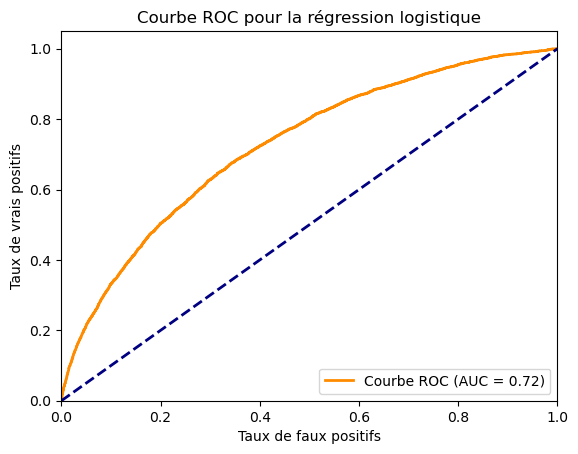

In [141]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculer la probabilité des prédictions pour les données de test
y_prob = grid_search.predict_proba(X_test_scaled)[:,1]

# Calculer la courbe ROC et l'aire sous la courbe (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC pour la régression logistique')
plt.legend(loc="lower right")
plt.show()

Vrai négatif (TN) :  43990
Faux positif (FP) :  21000
Faux négatif (FN) :  1740
Vrai positif (TP) :  3270
Matrice de confusion:
 [[43990 21000]
 [ 1740  3270]]


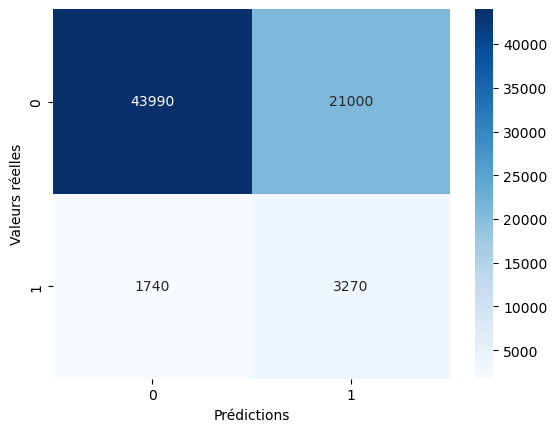

In [142]:
# supposons que y_true est la variable contenant les vraies étiquettes et y_pred est la variable contenant les prédictions du modèle
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# affichage des résultats
print("Vrai négatif (TN) : ", tn)
print("Faux positif (FP) : ", fp)
print("Faux négatif (FN) : ", fn)
print("Vrai positif (TP) : ", tp)

# calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# affichage de la matrice de confusion
print('Matrice de confusion:\n', cm)

# création de la heatmap avec Seaborn
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# personnalisation des labels des axes x et y
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')

# affichage de la figure
plt.show()

### Approche métier

In [143]:
def cost_function(y_test, y_pred):
    # Calcul du nombre de faux positifs et de faux négatifs
    fp = ((y_test == 0) & (y_pred == 1)).sum()
    fn = ((y_test == 1) & (y_pred == 0)).sum()

    # Calcul du coût en fonction du nombre de faux positifs et de faux négatifs
    cost = fp + 10 * fn

    return cost

import numpy as np

#y_test = np.array([0, 1, 0, 1, 0])
#y_pred = np.array([1, 1, 0, 0, 1])

cost_lr = cost_function(y_test, y_pred)
print(cost_lr)

38400


In [144]:
# Définition d'une fonction de test
def test_predictions():
    # Chargement des données
    df = pd.read_csv('df_scoring.csv')
    # Séparation des données en jeu de train et de test
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['TARGET'], axis=1), df['TARGET'], test_size=0.2, random_state=42)
    # Entraînement de l'algorithme de classification
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    # Prédictions sur le jeu de test
    y_pred = clf.predict(X_test)
    # Vérification que les prédictions sont binaires (0 ou 1)
    assert set(y_pred) == set([0, 1])
    # Calcul de l'accuracy de l'algorithme
    accuracy = clf.score(X_test, y_test)
    # Vérification que l'accuracy est supérieure ou égale à 0.8
    assert accuracy >= 0.8

# Application d'une méthode par arbre de décision

In [145]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)

# Calcul des probabilités de prédiction pour la classe positive
y_pred_dt_proba = dt.predict_proba(X_test_scaled)[:, 1]

accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, y_pred_dt_proba)

print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)
print("F1 score:", f1_dt)
print("AUC:", auc_dt)

2023/05/19 14:10:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bbd7a2c8ef9642449f8acc44094db4cb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Accuracy: 0.8600571428571429
Precision: 0.11240686750890833
Recall: 0.13852295409181636
F1 score: 0.12410586552217454
AUC: 0.5271011446870837


#### Classification Report

In [146]:
from sklearn.metrics import classification_report

# Afficher le rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.68      0.79     64990
           1       0.13      0.65      0.22      5010

    accuracy                           0.68     70000
   macro avg       0.55      0.66      0.51     70000
weighted avg       0.90      0.68      0.75     70000



#### Représentation graphique de l'AUC

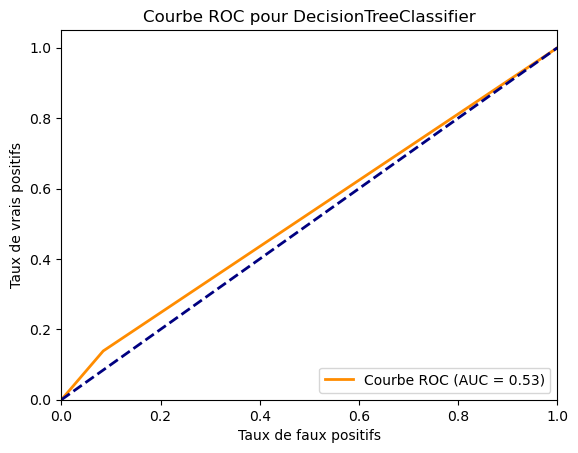

In [147]:
from sklearn.metrics import roc_curve, auc
# Calculer les probabilités prédites pour l'ensemble de test
y_proba = dt.predict_proba(X_test_scaled)[:, 1]

# Calculer la courbe ROC et l'AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC pour DecisionTreeClassifier')
plt.legend(loc="lower right")
plt.show()

#### Validation croisée

In [148]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

# Définir les hyperparamètres à tester
param_grid = {
    'max_depth': [None, 3, 5, 10]}

# Créer un modèle de Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)

# Définir la métrique à optimiser (AUC)
scoring = {'AUC': make_scorer(roc_auc_score)}

# Créer l'objet GridSearchCV pour la recherche des meilleurs hyperparamètres
grid_search = GridSearchCV(model, param_grid, scoring=scoring, refit='AUC', cv=5)

# Adapter le modèle sur les données d'apprentissage et évaluer sa performance en utilisant la validation croisée
grid_search.fit(X_train_scaled, y_train)

# Obtenir les meilleurs paramètres et la meilleure performance AUC
best_params = grid_search.best_params_
best_auc_dtc = grid_search.best_score_

# Utiliser le modèle avec les meilleurs paramètres pour prédire les valeurs de la variable cible dans l'ensemble de test
y_pred = grid_search.predict(X_test_scaled)

# Calculer l'AUC sur l'ensemble de test
test_auc_dtc = roc_auc_score(y_test, y_pred)

print("Meilleurs paramètres : ", best_params)
print("Meilleure AUC sur la validation croisée : ", best_auc_dtc)
print("AUC sur l'ensemble de test : ", test_auc_dtc)

2023/05/19 14:11:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '64984fa48ea54cfdb474215e104d7473', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/05/19 14:22:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/lib/python3.9/site-packages/mlflow/sklearn/utils.py:784: UserWarning: Top 5 child runs will be created based on ordering in rank_test_AUC column.  You can choose not to limit the number of child runs created by setting `max_tuning_runs=None`."
2023/05/19 14:22:55 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Meilleurs paramètres :  {'max_depth': 10}
Meilleure AUC sur la validation croisée :  0.9190937408915957
AUC sur l'ensemble de test :  0.5021748471052969


#### Matrice de confusion

Vrai négatif (TN) :  64663
Faux positif (FP) :  327
Faux négatif (FN) :  4963
Vrai positif (TP) :  47
Matrice de confusion:
 [[64663   327]
 [ 4963    47]]


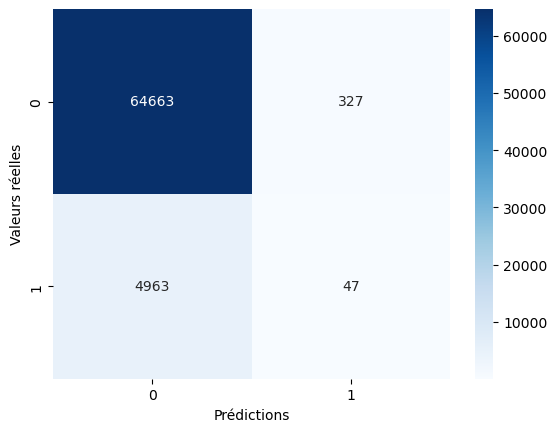

In [149]:
# supposons que y_true est la variable contenant les vraies étiquettes et y_pred est la variable contenant les prédictions du modèle
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# affichage des résultats
print("Vrai négatif (TN) : ", tn)
print("Faux positif (FP) : ", fp)
print("Faux négatif (FN) : ", fn)
print("Vrai positif (TP) : ", tp)

# calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# affichage de la matrice de confusion
print('Matrice de confusion:\n', cm)

# création de la heatmap avec Seaborn
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# personnalisation des labels des axes x et y
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')

# affichage de la figure
plt.show()

In [150]:
# supposons que y_true est la variable contenant les vraies étiquettes et y_pred est la variable contenant les prédictions du modèle
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# affichage des résultats
print("Vrai négatif (TN) : ", tn)
print("Faux positif (FP) : ", fp)
print("Faux négatif (FN) : ", fn)
print("Vrai positif (TP) : ", tp)

Vrai négatif (TN) :  64663
Faux positif (FP) :  327
Faux négatif (FN) :  4963
Vrai positif (TP) :  47


### Approche métier

In [151]:
def cost_function(y_test, y_pred):
    # Calcul du nombre de faux positifs et de faux négatifs
    fp = ((y_test == 0) & (y_pred == 1)).sum()
    fn = ((y_test == 1) & (y_pred == 0)).sum()

    # Calcul du coût en fonction du nombre de faux positifs et de faux négatifs
    cost = fp + 10 * fn

    return cost

import numpy as np

#y_test = np.array([0, 1, 0, 1, 0])
#y_pred = np.array([1, 1, 0, 0, 1])

cost_dt = cost_function(y_test, y_pred)
print(cost_dt)

49957


# Application d'une méthode par forêt aléatoire

In [94]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [95]:
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train_scaled, y_train)
y_pred_rf = random_forest.predict(X_test_scaled)

# Calcul des probabilités de prédiction pour la classe positive
y_pred_rf_proba = random_forest.predict_proba(X_test_scaled)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_rf_proba)

print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 score:", f1_rf)
print("AUC:", auc_rf)

2023/05/19 10:51:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8605bc7ed6094fbc8a0a2e17e5191d7d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Accuracy: 0.9293714285714286
Precision: 0.25301204819277107
Recall: 0.004283091984499286
F1 score: 0.00842358604091456
AUC: 0.6907834954630893


In [96]:
# Créer le modèle de classification
rf = RandomForestClassifier()

# Effectuer une validation croisée sur le modèle
scores = cross_val_score(rf, X_train_scaled, y_train, cv=5)

# Évaluer la performance du modèle en utilisant la précision et la matrice de confusion
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Précision : ", accuracy)
# Évaluer la performance du modèle en utilisant la précision et la matrice de confusion
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

Précision :  0.9267428571428571


#### Classification report

In [97]:
from sklearn.metrics import classification_report

# Afficher le rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     65097
           1       0.16      0.01      0.02      4903

    accuracy                           0.93     70000
   macro avg       0.54      0.50      0.49     70000
weighted avg       0.88      0.93      0.90     70000



#### Représentation graphique de l'AUC

2023/05/19 11:28:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f74d20f6c2544ac49cce21c5d7230706', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


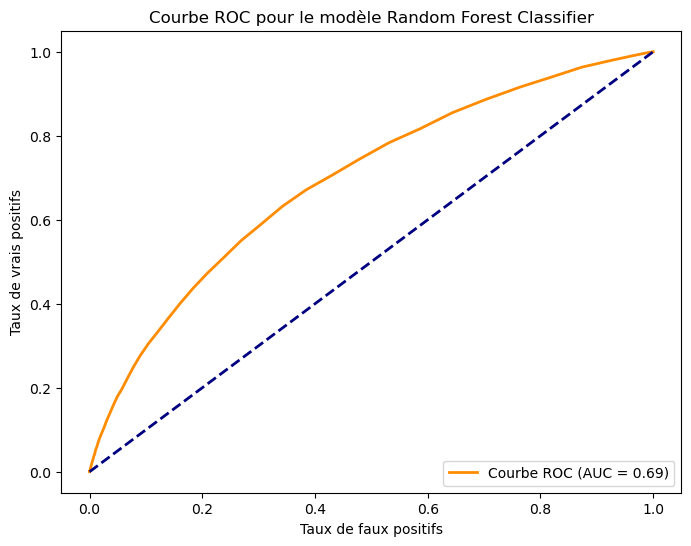

In [98]:
from sklearn.metrics import roc_curve, auc
# Créer et ajuster le modèle de classification
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)

# Faire des prédictions sur les données de test
y_pred_proba = rf.predict_proba(X_test_scaled)[:,1]

# Calculer la courbe ROC et l'aire sous la courbe (AUC)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC pour le modèle Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

#### Validation croisée

In [99]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Définir les hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200, 500]}

# Créer un modèle de Random Forest Classifier
model = RandomForestClassifier(random_state=42)

# Définir la métrique à optimiser (AUC)
scoring = {'AUC': make_scorer(roc_auc_score)}

# Créer l'objet GridSearchCV pour la recherche des meilleurs hyperparamètres
grid_search = GridSearchCV(model, param_grid, scoring=scoring, refit='AUC', cv=5)

# Adapter le modèle sur les données d'apprentissage et évaluer sa performance en utilisant la validation croisée
grid_search.fit(X_train_scaled, y_train)

# Obtenir les meilleurs paramètres et la meilleure performance AUC
best_params = grid_search.best_params_
best_auc_rfc = grid_search.best_score_

# Utiliser le modèle avec les meilleurs paramètres pour prédire les valeurs de la variable cible dans l'ensemble de test
y_pred = grid_search.predict(X_test_scaled)

# Calculer l'AUC sur l'ensemble de test
test_auc_rfc = roc_auc_score(y_test, y_pred)

print("Meilleurs paramètres : ", best_params)
print("Meilleure AUC sur la validation croisée : ", best_auc_rfc)
print("AUC sur l'ensemble de test : ", test_auc_rfc)

2023/05/19 11:37:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c92ee8f3e07d4c9c85e749cfcf5a5703', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


KeyboardInterrupt: 

#### Matrice de confusion

Vrai négatif (TN) :  64990
Faux positif (FP) :  0
Faux négatif (FN) :  5010
Vrai positif (TP) :  0
Matrice de confusion:
 [[64990     0]
 [ 5010     0]]


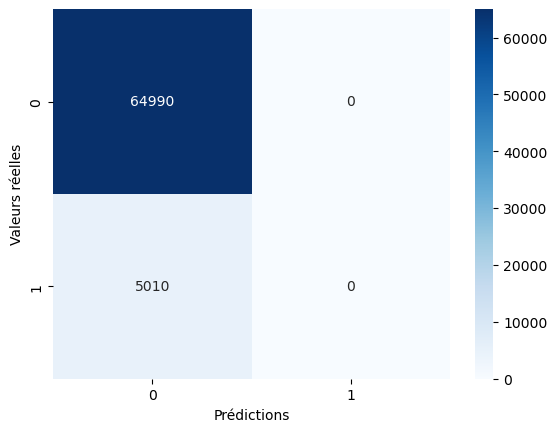

In [168]:
# supposons que y_true est la variable contenant les vraies étiquettes et y_pred est la variable contenant les prédictions du modèle
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# affichage des résultats
print("Vrai négatif (TN) : ", tn)
print("Faux positif (FP) : ", fp)
print("Faux négatif (FN) : ", fn)
print("Vrai positif (TP) : ", tp)

# calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# affichage de la matrice de confusion
print('Matrice de confusion:\n', cm)

# création de la heatmap avec Seaborn
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# personnalisation des labels des axes x et y
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')

# affichage de la figure
plt.show()

### Approche métier

In [169]:
def cost_function(y_test, y_pred):
    # Calcul du nombre de faux positifs et de faux négatifs
    fp = ((y_test == 0) & (y_pred == 1)).sum()
    fn = ((y_test == 1) & (y_pred == 0)).sum()

    # Calcul du coût en fonction du nombre de faux positifs et de faux négatifs
    cost = fp + 10 * fn

    return cost

import numpy as np

#y_test = np.array([0, 1, 0, 1, 0])
#y_pred = np.array([1, 1, 0, 0, 1])

cost_rf = cost_function(y_test, y_pred)
print(cost_rf)

50100


# Application d'une méthode par XGBoost

In [152]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_classifier.predict(X_test_scaled)

# Calcul des probabilités de prédiction pour la classe positive
y_pred_xgb_proba = xgb_classifier.predict_proba(X_test_scaled)[:, 1]

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_xgb_proba)

print("Accuracy:", accuracy_xgb)
print("Precision:", precision_xgb)
print("Recall:", recall_xgb)
print("F1 score:", f1_xgb)
print("AUC:", auc_xgb)

Accuracy: 0.9281
Precision: 0.45660377358490567
Recall: 0.024151696606786427
F1 score: 0.04587677725118484
AUC: 0.7370816867572747


#### Classification Report

In [153]:
# Afficher le classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     64990
           1       0.13      0.01      0.02      5010

    accuracy                           0.92     70000
   macro avg       0.53      0.50      0.49     70000
weighted avg       0.87      0.92      0.89     70000



#### Représentation graphique de l'AUC

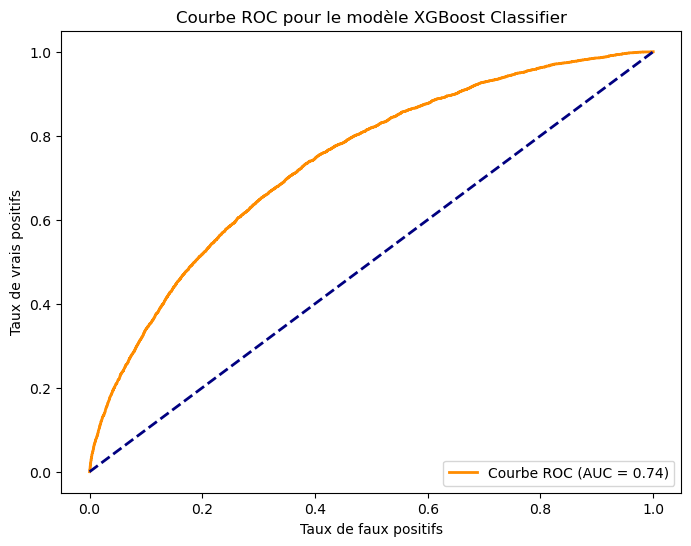

In [154]:
# Créer et ajuster le modèle de classification
xgb_model = XGBClassifier()
xgb_model.fit(X_train_scaled, y_train)

# Faire des prédictions sur les données de test
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Calculer la courbe ROC et l'aire sous la courbe (AUC)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC pour le modèle XGBoost Classifier')
plt.legend(loc="lower right")
plt.show()

#### Validation croisée

In [155]:
# Définir les hyperparamètres à tester
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001]}

# Créer un modèle XGBoost Classifier
model = XGBClassifier(random_state=42)

# Définir la métrique à optimiser (AUC)
scoring = {'AUC': make_scorer(roc_auc_score)}

# Créer l'objet GridSearchCV pour la recherche des meilleurs hyperparamètres
grid_search = GridSearchCV(model, param_grid, scoring=scoring, refit='AUC', cv=5)

# Adapter le modèle sur les données d'apprentissage et évaluer sa performance en utilisant la validation croisée
grid_search.fit(X_train_scaled, y_train)

# Obtenir les meilleurs paramètres et la meilleure performance AUC
best_params = grid_search.best_params_
best_auc_xgb = grid_search.best_score_

# Utiliser le modèle avec les meilleurs paramètres pour prédire les valeurs de la variable cible dans l'ensemble de test
y_pred = grid_search.predict(X_test_scaled)

# Calculer l'AUC sur l'ensemble de test
test_auc_xgb = roc_auc_score(y_test, y_pred)

print("Meilleurs paramètres : ", best_params)
print("Meilleure AUC sur la validation croisée : ", best_auc_xgb)
print("AUC sur l'ensemble de test : ", test_auc_xgb)


2023/05/19 14:31:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0053fd87c4fe427d87074d980f56b58e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/05/19 14:31:12 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
             ...`
2023/05/19 15:20:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/lib/python3.9/s

Meilleurs paramètres :  {'learning_rate': 0.1}
Meilleure AUC sur la validation croisée :  0.9601692206071138
AUC sur l'ensemble de test :  0.5012433357626953


#### Matrice de confusion

Vrai négatif (TN) :  64970
Faux positif (FP) :  20
Faux négatif (FN) :  4996
Vrai positif (TP) :  14
Matrice de confusion:
 [[64970    20]
 [ 4996    14]]


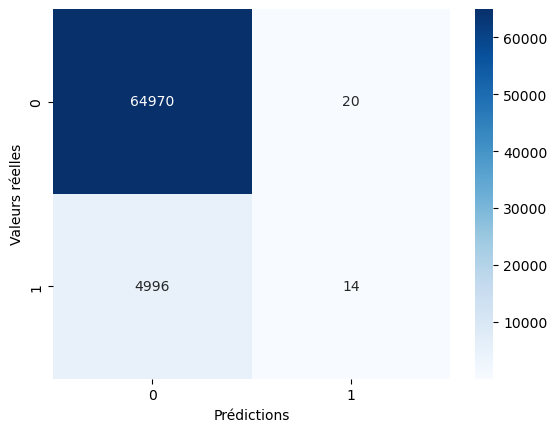

In [156]:
# supposons que y_true est la variable contenant les vraies étiquettes et y_pred est la variable contenant les prédictions du modèle
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# affichage des résultats
print("Vrai négatif (TN) : ", tn)
print("Faux positif (FP) : ", fp)
print("Faux négatif (FN) : ", fn)
print("Vrai positif (TP) : ", tp)

# calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# affichage de la matrice de confusion
print('Matrice de confusion:\n', cm)

# création de la heatmap avec Seaborn
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# personnalisation des labels des axes x et y
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')

# affichage de la figure
plt.show()

### Approche métier

In [157]:
def cost_function(y_test, y_pred):
    # Calcul du nombre de faux positifs et de faux négatifs
    fp = ((y_test == 0) & (y_pred == 1)).sum()
    fn = ((y_test == 1) & (y_pred == 0)).sum()

    # Calcul du coût en fonction du nombre de faux positifs et de faux négatifs
    cost = fp + 10 * fn

    return cost

import numpy as np

#y_test = np.array([0, 1, 0, 1, 0])
#y_pred = np.array([1, 1, 0, 0, 1])

cost_xgb = cost_function(y_test, y_pred)
print(cost_xgb)

49980


# Application d'une méthode par DummyClassifier

In [158]:
from sklearn.metrics import roc_auc_score

dummy = DummyClassifier(random_state=42)
dummy.fit(X_train_scaled, y_train)
y_pred_dummy = dummy.predict(X_test_scaled)

# Calcul des probabilités de prédiction pour la classe positive
y_pred_dummy_proba = dummy.predict_proba(X_test_scaled)[:, 1]

accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
precision_dummy = precision_score(y_test, y_pred_dummy)
recall_dummy = recall_score(y_test, y_pred_dummy)
f1_dummy = f1_score(y_test, y_pred_dummy)
auc_dummy = roc_auc_score(y_test, y_pred_dummy_proba)

print("Accuracy:", accuracy_dummy)
print("Precision:", precision_dummy)
print("Recall:", recall_dummy)
print("F1 score:", f1_dummy)
print("AUC:", auc_dummy)

2023/05/19 15:21:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fc3f1ab38de34cb6b36cec47d04e4f67', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Accuracy: 0.9284285714285714
Precision: 0.0
Recall: 0.0
F1 score: 0.0
AUC: 0.5


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


#### Classification Report

In [159]:
# Afficher le classification report
print(classification_report(y_test, y_pred_dummy))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     64990
           1       0.00      0.00      0.00      5010

    accuracy                           0.93     70000
   macro avg       0.46      0.50      0.48     70000
weighted avg       0.86      0.93      0.89     70000



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


#### Représentation graphique de l'AUC

2023/05/19 15:21:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '078868f34efa4fd89a389683e5bae4f1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


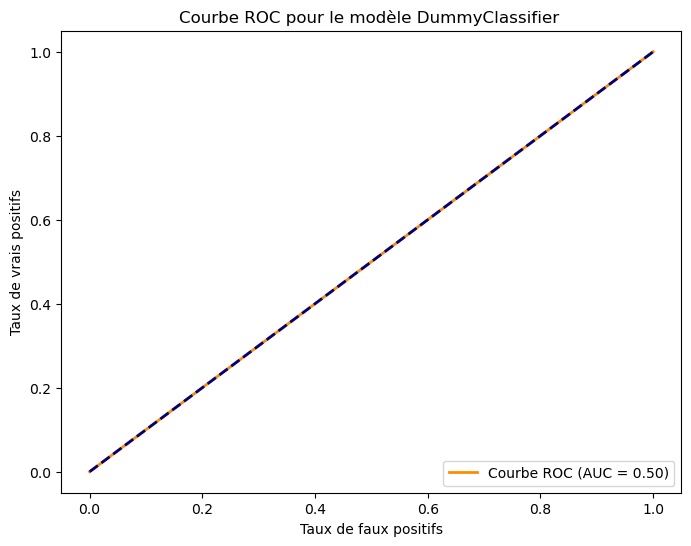

In [160]:
# Instancier un classifieur DummyClassifier qui prédit la classe majoritaire dans l'ensemble d'entraînement
dummy = DummyClassifier(strategy='most_frequent')

# Entraîner le classifieur sur les données d'entraînement
dummy.fit(X_train_scaled, y_train)

# Faire des prédictions sur les données de test
y_pred_proba = dummy.predict_proba(X_test_scaled)[:, 1]

# Calculer la courbe ROC et l'aire sous la courbe (AUC)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC pour le modèle DummyClassifier ')
plt.legend(loc="lower right")
plt.show()

#### Validation croisée

In [161]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.dummy import DummyClassifier

# Définir les hyperparamètres à tester
param_grid = {
    'strategy': ['stratified', 'most_frequent', 'prior', 'uniform']
}

# Créer un modèle Dummy Classifier
model = DummyClassifier(random_state=42)

# Définir la métrique à optimiser (AUC)
scoring = {'AUC': make_scorer(roc_auc_score)}

# Créer l'objet GridSearchCV pour la recherche des meilleurs hyperparamètres
grid_search = GridSearchCV(model, param_grid, scoring=scoring, refit='AUC', cv=5)

# Adapter le modèle sur les données d'apprentissage et évaluer sa performance en utilisant la validation croisée
grid_search.fit(X_train_scaled, y_train)

# Obtenir les meilleurs paramètres et la meilleure performance AUC
best_params = grid_search.best_params_
best_auc_dc = grid_search.best_score_

# Utiliser le modèle avec les meilleurs paramètres pour prédire les valeurs de la variable cible dans l'ensemble de test
y_pred = grid_search.predict(X_test_scaled)

# Calculer l'AUC sur l'ensemble de test
test_auc_dc = roc_auc_score(y_test, y_pred)

print("Meilleurs paramètres : ", best_params)
print("Meilleure AUC sur la validation croisée : ", best_auc_dc)
print("AUC sur l'ensemble de test : ", test_auc_dc)

2023/05/19 15:21:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6b6c5a890e3f4a289533f7d6bff3952f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/05/19 15:22:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/lib/python3.9/site-packages/mlflow/sklearn/utils.py:784: UserWarning: Top 5 child runs will be created based on ordering in rank_test_AUC column.  You can choose not to limit the number of child runs created by setting `max_tuning_runs=None`."
2023/05/19 15:22:08 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Meilleurs paramètres :  {'strategy': 'uniform'}
Meilleure AUC sur la validation croisée :  0.5016996491950996
AUC sur l'ensemble de test :  0.4989622386247662


#### Matrice de confusion

2023/05/19 15:22:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7c57eb45ba2445d3b38078419c853360', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Matrice de confusion :
[[64990     0]
 [ 5010     0]]


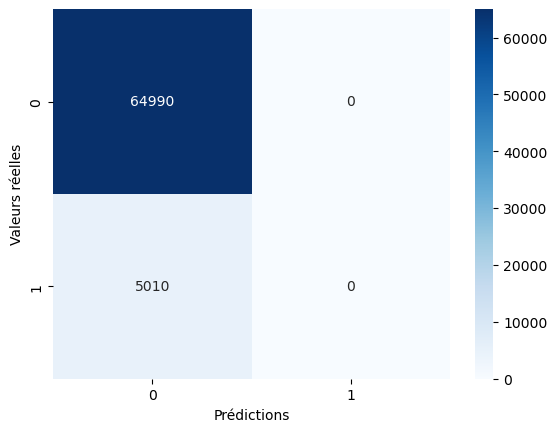

In [162]:
# Instancier un classifieur DummyClassifier qui prédit la classe majoritaire dans l'ensemble d'entraînement
dummy = DummyClassifier(strategy='most_frequent')

# Entraîner le classifieur sur les données d'entraînement
dummy.fit(X_train_scaled, y_train)

# Faire des prédictions sur les données de test
y_pred = dummy.predict(X_test_scaled)

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Afficher les résultats
print("Matrice de confusion :")
print(cm)

# Afficher la matrice de confusion sous forme de heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()

#### Approche métier

In [163]:
def cost_function(y_test, y_pred):
    # Calcul du nombre de faux positifs et de faux négatifs
    fp = ((y_test == 0) & (y_pred == 1)).sum()
    fn = ((y_test == 1) & (y_pred == 0)).sum()

    # Calcul du coût en fonction du nombre de faux positifs et de faux négatifs
    cost = fp + 10 * fn

    return cost

import numpy as np

#y_test = np.array([0, 1, 0, 1, 0])
#y_pred = np.array([1, 1, 0, 0, 1])

cost_dummy = cost_function(y_test, y_pred)
print(cost_dummy)

50100


# Evaluation des modèles

In [164]:
# Régression Logistique
lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_lr)


# Arbre de Décision
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, y_pred_dt_proba)

# Forêt Aléatoire
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_rf_proba)

# XGBoost
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_xgb_proba)

# DummyClassifier
dummy = DummyClassifier(random_state=42)
dummy.fit(X_train_scaled, y_train)
y_pred_dummy = dummy.predict(X_test_scaled)
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
precision_dummy = precision_score(y_test, y_pred_dummy)
recall_dummy = recall_score(y_test, y_pred_dummy)
f1_dummy = f1_score(y_test, y_pred_dummy)
auc_dummy = roc_auc_score(y_test, y_pred_dummy_proba)



# Afficher les résultats
print("Régression Logistique:")
print("Accuracy : ", accuracy_lr)
print("Précision : ", precision_lr)
print("Rappel : ", recall_lr)
print("F1-Score : ", f1_lr)
print("AUC:", auc_lr)
print()
print("Arbre de Décision:")
print("Accuracy : ", accuracy_dt)
print("Précision : ", precision_dt)
print("Rappel : ", recall_dt)
print("F1-Score : ", f1_dt)
print("AUC:", auc_dt)
print()
print("Forêt Aléatoire:")
print("Accuracy : ", accuracy_rf)
print("Précision : ", precision_rf)
print("Rappel : ", recall_rf)
print("F1-Score : ", f1_rf)
print("AUC:", auc_rf)
print()
print("XGBoost:")
print("Accuracy : ", accuracy_xgb)
print("Précision : ", precision_xgb)
print("Rappel : ", recall_xgb)
print("F1-Score : ", f1_xgb)
print("AUC:", auc_xgb)
print()
print("Dummy:")
print("Accuracy : ", accuracy_dummy)
print("Précision : ", precision_dummy)
print("Rappel : ", recall_dummy)
print("F1-Score : ", f1_dummy)
print("AUC:", auc_dummy)

2023/05/19 15:22:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f3f1561e0aec42228af22132aaa61f0f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
2023/05/19 15:23:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3ceabf979a5041a0b035442acba24ad1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/05/19 15:24:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '765612

Régression Logistique:
Accuracy :  0.6751571428571429
Précision :  0.13470968805373554
Rappel :  0.65249500998004
F1-Score :  0.22331523038562698
AUC: 0.6646995745391814

Arbre de Décision:
Accuracy :  0.8600571428571429
Précision :  0.11240686750890833
Rappel :  0.13852295409181636
F1-Score :  0.12410586552217454
AUC: 0.5271011446870837

Forêt Aléatoire:
Accuracy :  0.9282285714285714
Précision :  0.36538461538461536
Rappel :  0.0037924151696606787
F1-Score :  0.007506914263137101
AUC: 0.4989090690752669

XGBoost:
Accuracy :  0.9281
Précision :  0.45660377358490567
Rappel :  0.024151696606786427
F1-Score :  0.04587677725118484
AUC: 0.7370816867572747

Dummy:
Accuracy :  0.9284285714285714
Précision :  0.0
Rappel :  0.0
F1-Score :  0.0
AUC: 0.5


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [170]:
# Création d'un dictionnaire de données avec 6 colonnes
data = {
        'Modèle': ['Régression Logistique', 'DecisionTreeClassifier', 'RandomForestClassifier', 'XGBoost', 'DummyClassifier'],
        'Accuracy': [accuracy_lr, accuracy_dt, accuracy_rf, accuracy_xgb, accuracy_dummy],
        'AUC':[auc_lr, auc_dt, auc_rf, auc_xgb, auc_dummy],
        'Précision': [precision_rf, precision_dt, precision_rf, precision_xgb, precision_dummy],
        'Rappel': [recall_lr, recall_dt, recall_rf, recall_xgb, recall_dummy],
        'F1-Score': [f1_lr, f1_dt, f1_rf, f1_xgb, f1_dummy],
        'Coût risqué': [cost_lr, cost_dt, cost_rf, cost_xgb, cost_dummy]
       }

# Création du DataFrame à partir du dictionnaire de données
df_comparaison = pd.DataFrame(data)

# Affichage du DataFrame
print(df_comparaison)

                   Modèle  Accuracy       AUC  Précision    Rappel  F1-Score  \
0   Régression Logistique  0.675157  0.664700   0.365385  0.652495  0.223315   
1  DecisionTreeClassifier  0.860057  0.527101   0.112407  0.138523  0.124106   
2  RandomForestClassifier  0.928229  0.498909   0.365385  0.003792  0.007507   
3                 XGBoost  0.928100  0.737082   0.456604  0.024152  0.045877   
4         DummyClassifier  0.928429  0.500000   0.000000  0.000000  0.000000   

   Coût risqué  
0        38400  
1        49957  
2        50100  
3        49980  
4        50100  


In [171]:
df_comparaison.head()

,Modèle,Accuracy,AUC,Précision,Rappel,F1-Score,Coût risqué
0,Régression Logistique,0.675157,0.664700,0.365385,0.652495,0.223315,38400
1,DecisionTreeClassifier,0.860057,0.527101,0.112407,0.138523,0.124106,49957
2,RandomForestClassifier,0.928229,0.498909,0.365385,0.003792,0.007507,50100
3,XGBoost,0.928100,0.737082,0.456604,0.024152,0.045877,49980
4,DummyClassifier,0.928429,0.500000,0.000000,0.000000,0.000000,50100


### Comparaison des AUC

In [173]:
comparaison_auc = {
        'Modèle': ['Régression Logistique', 'DecisionTreeClassifier', 'XGBoost', 'DummyClassifier'],
        'AUC':[auc_lr, auc_dt, auc_xgb, auc_dummy],
        'AUC Améliorée':[best_auc_lr, best_auc_dtc, best_auc_xgb, best_auc_dc]}

In [174]:
# Création du DataFrame à partir du dictionnaire de données
comparaison_auc = pd.DataFrame(comparaison_auc)

comparaison_auc.head()

,Modèle,AUC,AUC Améliorée
0,Régression Logistique,0.664700,0.688022
1,DecisionTreeClassifier,0.527101,0.919094
2,XGBoost,0.737082,0.960169
3,DummyClassifier,0.500000,0.501700


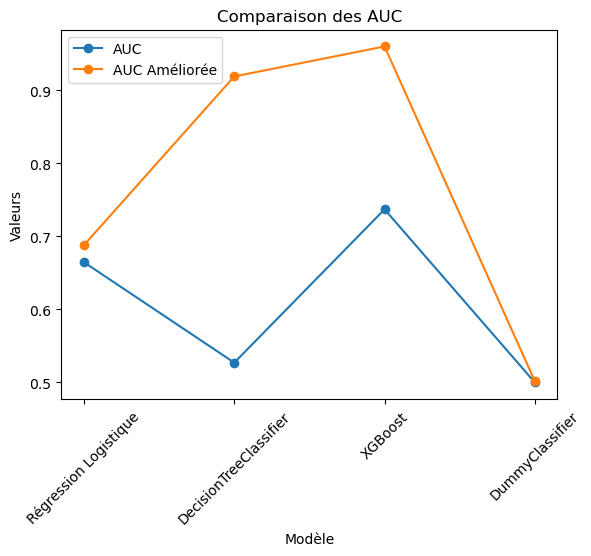

In [175]:
# Tracé du graphique
plt.plot(comparaison_auc['Modèle'], comparaison_auc['AUC'], marker='o', label='AUC')
plt.plot(comparaison_auc['Modèle'], comparaison_auc['AUC Améliorée'], marker='o', label='AUC Améliorée')

# Ajout des légendes et des titres
plt.xticks(rotation=45)
plt.legend()
plt.xlabel('Modèle')
plt.ylabel('Valeurs')
plt.title('Comparaison des AUC')

# Affichage du graphique
plt.show()

### Représentation des coûts risqués

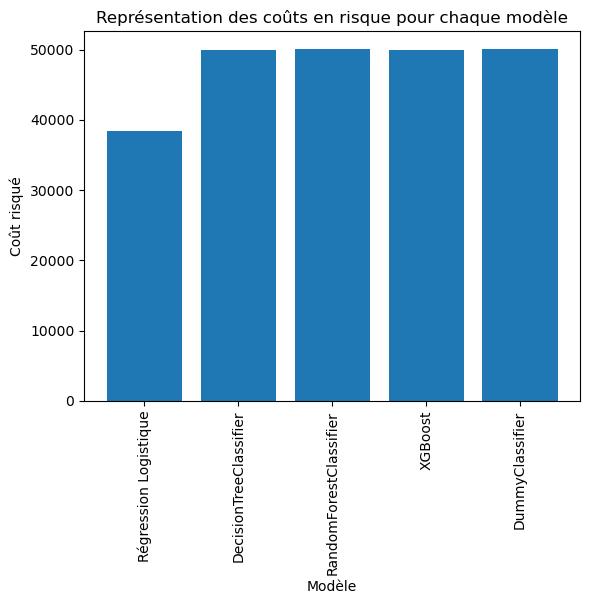

In [176]:
# Tracé d'un graphique à barres
plt.bar(df_comparaison['Modèle'], df_comparaison['Coût risqué'])
plt.title('Représentation des coûts en risque pour chaque modèle')
plt.xlabel('Modèle')
plt.ylabel('Coût risqué')
plt.xticks(rotation=90)
plt.show()

# Interprétabilités locale et globale avec SHAP

In [177]:
# train XGBoost model
import xgboost
model_xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=2).fit(X, y)

# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(model_xgb)
shap_values_xgb = explainer_xgb(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [178]:
# make a standard partial dependence plot with a single SHAP value overlaid
fig,ax = shap.partial_dependence_plot(
    "MedInc", model_xgb.predict, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_xgb[sample_ind:sample_ind+1,:])

NameError: name 'sample_ind' is not defined

In [179]:
# print the JS visualization code to the notebook
shap.initjs()

In [180]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X)

    # visualize the first prediction's explanation

shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:]) # matplotlib=True

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


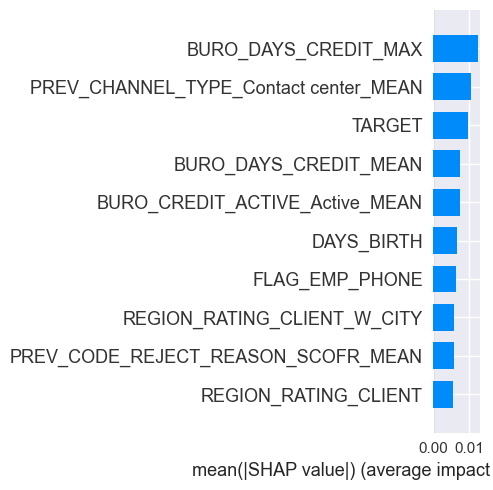

In [218]:
# SHAP explanations
shap.initjs()
shap_explainer = shap.TreeExplainer(model_xgb)
shap_values = shap_explainer.shap_values(X)
shap.summary_plot(shap_values,
                  X_test,
                  feature_names=top_corr_cols,
                  max_display=10,
                  plot_type='bar',
                  plot_size=(5, 5))
plt.show()

# Interprétabilité globale

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


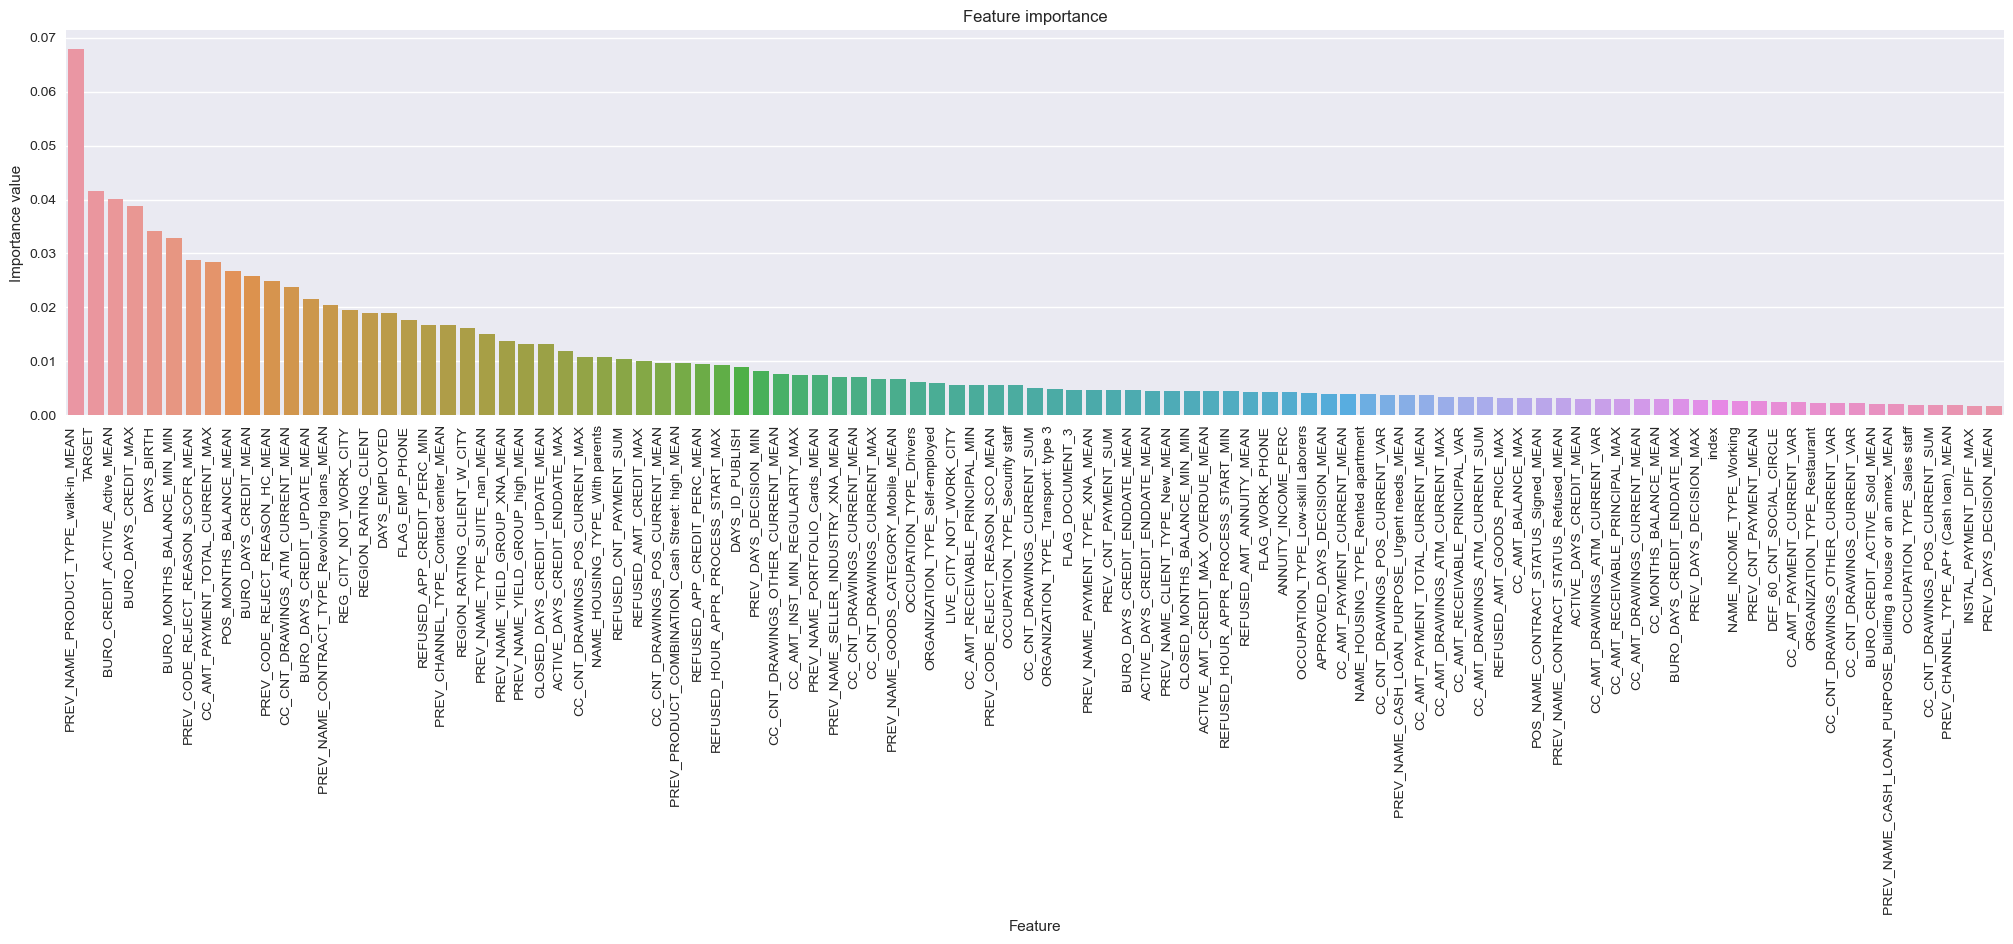

In [182]:
# Displaying the Feature importance
features_importance = model_xgb.feature_importances_
sorted_features = np.argsort(features_importance)
features_df = pd.DataFrame(columns=['Feature', 'Importance value', ''])
features_df['Feature'] = np.array(list(top_corr_cols))[sorted_features]
features_df['Importance value'] = features_importance[sorted_features]
features_df = features_df.sort_values(['Importance value'],
                                      ascending=False)
relevant_features = list(features_df.Feature)
features_df = features_df[features_df['Importance value'] > 0]

# Plot
# Setting up the figure
plt.style.use('seaborn')
fig = plt.figure(figsize=(25, 5))
ax = sns.barplot(x='Feature', y='Importance value', data=features_df)
fig = ax.get_figure()
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    ha='right')
ax.set_title('Feature importance')
ax.set_xlabel('Feature')
ax.set_ylabel('Importance value')
plt.show()

# Réintégration de la colonne SK_ID_CURR

In [183]:
print(df.columns)

Index(['TARGET', 'BURO_DAYS_CREDIT_MEAN', 'DAYS_BIRTH',
       'PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 'BURO_DAYS_CREDIT_MIN',
       'CLOSED_DAYS_CREDIT_MIN', 'CLOSED_DAYS_CREDIT_MEAN',
       'BURO_DAYS_CREDIT_UPDATE_MEAN', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
       'REGION_RATING_CLIENT_W_CITY',
       ...
       'INSTAL_DPD_MEAN', 'CC_CNT_DRAWINGS_POS_CURRENT_MIN',
       'CC_AMT_PAYMENT_CURRENT_VAR', 'BURO_STATUS_5_MEAN_MEAN',
       'ORGANIZATION_TYPE_Industry: type 3', 'ORGANIZATION_TYPE_Restaurant',
       'PREV_NAME_CONTRACT_TYPE_XNA_MEAN', 'PREV_PRODUCT_COMBINATION_nan_MEAN',
       'BURO_STATUS_3_MEAN_MEAN', 'CC_NAME_CONTRACT_STATUS_Active_MEAN'],
      dtype='object', length=200)


In [184]:
# Réintégrer la colonne "Identifiant client" dans votre DataFrame
df.insert(loc=0, column="SK_ID_CURR", value=df0["SK_ID_CURR"])
df.head()

,SK_ID_CURR,TARGET,BURO_DAYS_CREDIT_MEAN,DAYS_BIRTH,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,BURO_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,...,INSTAL_DPD_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_PAYMENT_CURRENT_VAR,BURO_STATUS_5_MEAN_MEAN,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Restaurant,PREV_NAME_CONTRACT_TYPE_XNA_MEAN,PREV_PRODUCT_COMBINATION_nan_MEAN,BURO_STATUS_3_MEAN_MEAN,CC_NAME_CONTRACT_STATUS_Active_MEAN
0,151159.0,0,-1358.869565,-14735.0,0.000000,-2740.0,-2740.0,-1626.75,-993.565217,0.0,...,0.480769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,104920.0,0,-1664.000000,-13408.0,0.000000,-2590.0,-2590.0,-1664.00,-1433.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,327707.0,0,-1314.500000,-18888.0,0.000000,-1516.0,-1516.0,-1516.00,-489.500000,0.0,...,0.105263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,167719.0,0,-666.545455,-10587.0,0.142857,-1221.0,-1221.0,-975.50,-228.454545,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,145559.0,0,-744.500000,-8343.0,0.000000,-1126.0,0.0,0.00,-16.500000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Ajout d'une colonne donnant l'âge en valeur absolue

In [185]:
# Convertir les jours en années en utilisant la valeur absolue
df['AGE'] = abs(df['DAYS_BIRTH']) // 365
df.head()

,SK_ID_CURR,TARGET,BURO_DAYS_CREDIT_MEAN,DAYS_BIRTH,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,BURO_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,...,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_PAYMENT_CURRENT_VAR,BURO_STATUS_5_MEAN_MEAN,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Restaurant,PREV_NAME_CONTRACT_TYPE_XNA_MEAN,PREV_PRODUCT_COMBINATION_nan_MEAN,BURO_STATUS_3_MEAN_MEAN,CC_NAME_CONTRACT_STATUS_Active_MEAN,AGE
0,151159.0,0,-1358.869565,-14735.0,0.000000,-2740.0,-2740.0,-1626.75,-993.565217,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0
1,104920.0,0,-1664.000000,-13408.0,0.000000,-2590.0,-2590.0,-1664.00,-1433.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0
2,327707.0,0,-1314.500000,-18888.0,0.000000,-1516.0,-1516.0,-1516.00,-489.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,51.0
3,167719.0,0,-666.545455,-10587.0,0.142857,-1221.0,-1221.0,-975.50,-228.454545,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
4,145559.0,0,-744.500000,-8343.0,0.000000,-1126.0,0.0,0.00,-16.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0


In [186]:
print(df.columns)

Index(['SK_ID_CURR', 'TARGET', 'BURO_DAYS_CREDIT_MEAN', 'DAYS_BIRTH',
       'PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 'BURO_DAYS_CREDIT_MIN',
       'CLOSED_DAYS_CREDIT_MIN', 'CLOSED_DAYS_CREDIT_MEAN',
       'BURO_DAYS_CREDIT_UPDATE_MEAN', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
       ...
       'CC_CNT_DRAWINGS_POS_CURRENT_MIN', 'CC_AMT_PAYMENT_CURRENT_VAR',
       'BURO_STATUS_5_MEAN_MEAN', 'ORGANIZATION_TYPE_Industry: type 3',
       'ORGANIZATION_TYPE_Restaurant', 'PREV_NAME_CONTRACT_TYPE_XNA_MEAN',
       'PREV_PRODUCT_COMBINATION_nan_MEAN', 'BURO_STATUS_3_MEAN_MEAN',
       'CC_NAME_CONTRACT_STATUS_Active_MEAN', 'AGE'],
      dtype='object', length=202)


# Sauvegarde du modèle de prédiction

In [187]:
from pickle import dump, load
with open("model.pickle", "wb") as file:
    dump(xgb,file)

In [188]:
with open("model.pickle", "rb") as file:
    model=load(file)

In [189]:
print(df.columns)

Index(['SK_ID_CURR', 'TARGET', 'BURO_DAYS_CREDIT_MEAN', 'DAYS_BIRTH',
       'PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 'BURO_DAYS_CREDIT_MIN',
       'CLOSED_DAYS_CREDIT_MIN', 'CLOSED_DAYS_CREDIT_MEAN',
       'BURO_DAYS_CREDIT_UPDATE_MEAN', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
       ...
       'CC_CNT_DRAWINGS_POS_CURRENT_MIN', 'CC_AMT_PAYMENT_CURRENT_VAR',
       'BURO_STATUS_5_MEAN_MEAN', 'ORGANIZATION_TYPE_Industry: type 3',
       'ORGANIZATION_TYPE_Restaurant', 'PREV_NAME_CONTRACT_TYPE_XNA_MEAN',
       'PREV_PRODUCT_COMBINATION_nan_MEAN', 'BURO_STATUS_3_MEAN_MEAN',
       'CC_NAME_CONTRACT_STATUS_Active_MEAN', 'AGE'],
      dtype='object', length=202)


In [190]:
df.head()

,SK_ID_CURR,TARGET,BURO_DAYS_CREDIT_MEAN,DAYS_BIRTH,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,BURO_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,...,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_PAYMENT_CURRENT_VAR,BURO_STATUS_5_MEAN_MEAN,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Restaurant,PREV_NAME_CONTRACT_TYPE_XNA_MEAN,PREV_PRODUCT_COMBINATION_nan_MEAN,BURO_STATUS_3_MEAN_MEAN,CC_NAME_CONTRACT_STATUS_Active_MEAN,AGE
0,151159.0,0,-1358.869565,-14735.0,0.000000,-2740.0,-2740.0,-1626.75,-993.565217,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0
1,104920.0,0,-1664.000000,-13408.0,0.000000,-2590.0,-2590.0,-1664.00,-1433.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0
2,327707.0,0,-1314.500000,-18888.0,0.000000,-1516.0,-1516.0,-1516.00,-489.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,51.0
3,167719.0,0,-666.545455,-10587.0,0.142857,-1221.0,-1221.0,-975.50,-228.454545,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
4,145559.0,0,-744.500000,-8343.0,0.000000,-1126.0,0.0,0.00,-16.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0


import requests

# Analyse du DataDrift à l'aide de la Bibliothèque Evidently

In [191]:
df_train = pd.read_csv("application_train.csv")
df_test=pd.read_csv("application_test.csv")

La présence de la colonne TARGET dans la base de données Train nous incite à provoquer son emplacement dans la base de données Test.

In [192]:
df_test = df_test.join(df_train["TARGET"])

In [193]:
from evidently import ColumnMapping
from evidently.options import ColorOptions
from evidently.report import Report

In [194]:
#dataset-level metrics
data_drift_dataset_report = Report(metrics=[
    DataDriftTable(num_stattest='kl_div', cat_stattest='psi'),    
])

data_drift_dataset_report.run(reference_data=df_train, current_data=df_test)
data_drift_dataset_report

NameError: name 'DataDriftTable' is not defined

In [195]:
data_drift_dataset_report.save_html('Datadrift.html')

NameError: name 'data_drift_dataset_report' is not defined

# Représentations graphiques diverses

#### Représentation graphique des âges de la clientèle

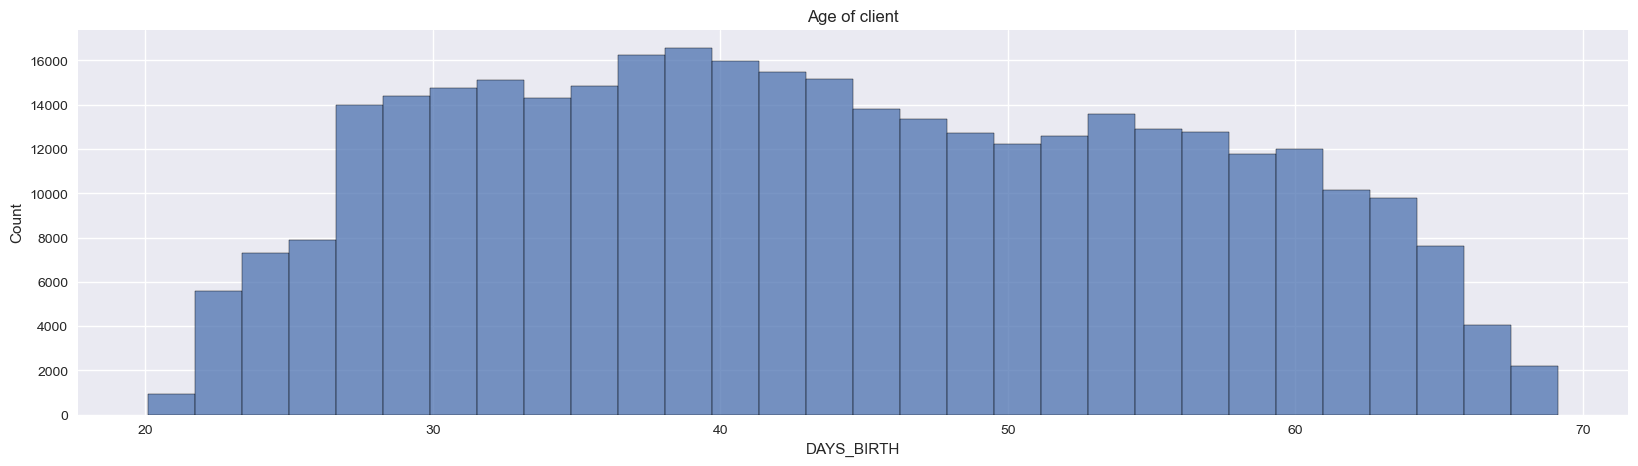

In [196]:
plt.figure(figsize=(20, 5))
sns.histplot((df['DAYS_BIRTH'] / -365), bins = 30).set_title('Age of client')
plt.show()

#### Représentation de la distribution de la "Target" en fonction de l'âge du client

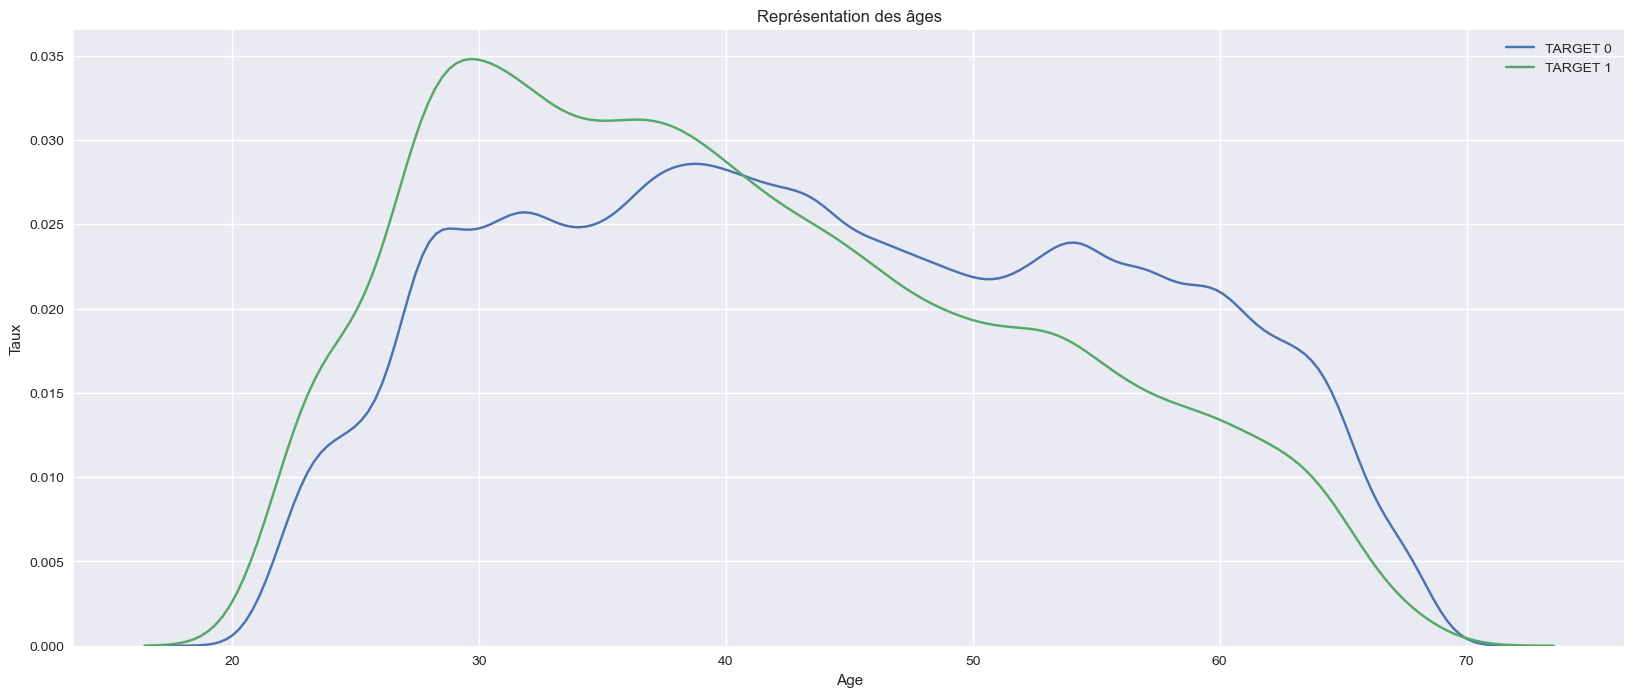

In [197]:
plt.figure(figsize = (20, 8))
sns.kdeplot(df[df['TARGET'] == 0]['DAYS_BIRTH'] / -365, label = 'TARGET 0')
sns.kdeplot(df[df['TARGET'] == 1]['DAYS_BIRTH'] / -365, label = 'TARGET 1')

plt.legend(), plt.xlabel('Age'), plt.ylabel('Taux'), plt.title('Représentation des âges')
plt.show()

<Axes: xlabel='NAME_INCOME_TYPE_Working', ylabel='Density'>

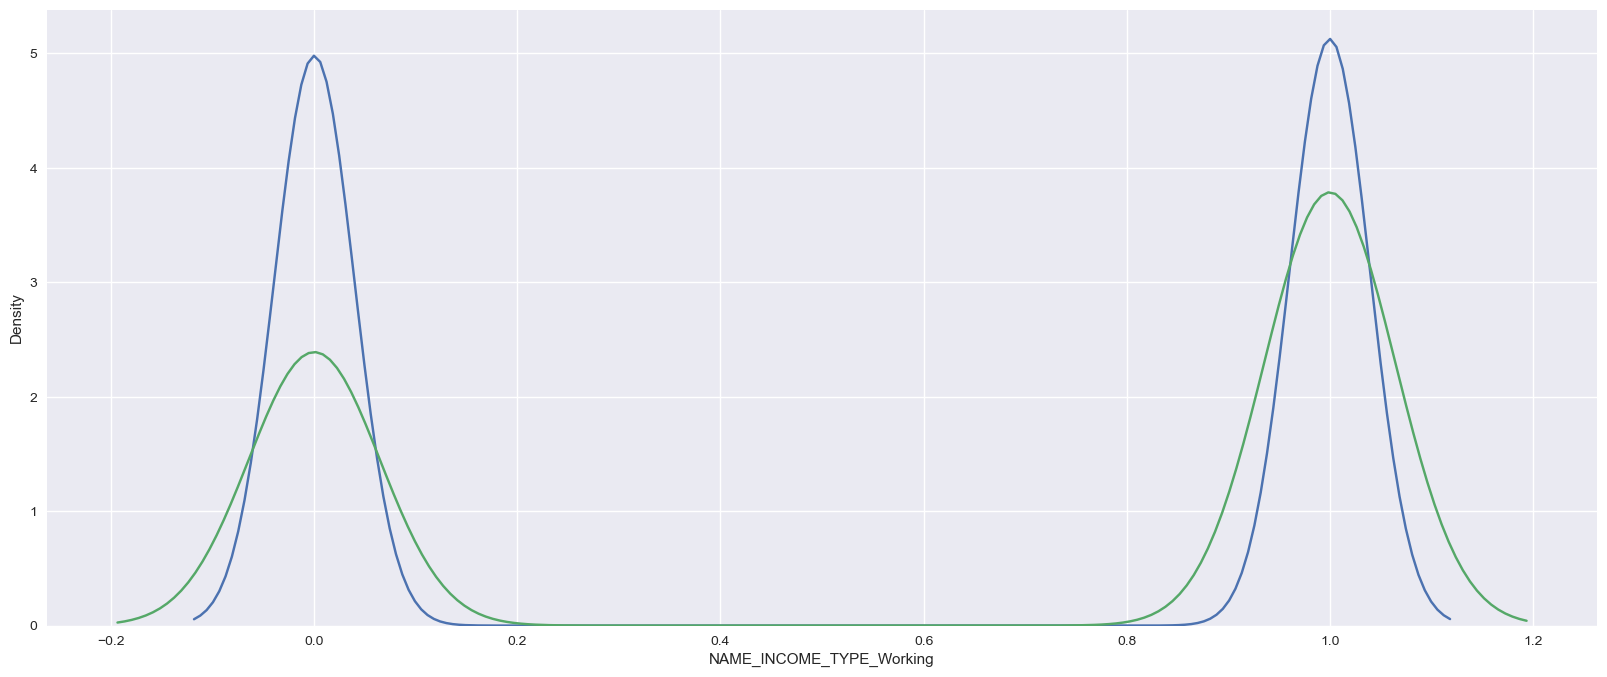

In [199]:
plt.figure(figsize = (20, 8))
sns.kdeplot(df[df['TARGET'] == 0]['NAME_INCOME_TYPE_Working'], label = 'TARGET 0')
sns.kdeplot(df[df['TARGET'] == 1]['NAME_INCOME_TYPE_Working'], label = 'TARGET 1')